In [ ]:
# https://www.tensorflow.org/tutorials/text/nmt_with_attention
import tensorflow as tf
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import io
import time

In [ ]:
import os
import librosa # for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile # for audio processing
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def read_wav(PATH, LABELS=None, SAMPLE=None, default_rate=8000):
    if LABELS is None:
        LABELS = [f for f in os.listdir(os.getcwd()) if os.path.isdir(os.getcwd() + "\\" + f)]
        
    label_len = len(LABELS)

    # initialize the output array
    wave_count = np.zeros(label_len, dtype=np.int32)
    loss_count = np.zeros(label_len, dtype=np.int32)

    print("LABEL\tTOTAL\tREAD\t<1s COUNT")
    print("-----\t-----\t----\t---------")
    for i, label in enumerate(LABELS):
        files = os.listdir(os.path.join(PATH, label))                                 # list all the files
        waves = [f for f in files if f.endswith('.wav')]                              # get wave files
        wave_len = len(waves)                                                         # get number of wave files
        wave_count[i] = wave_len
        
        if SAMPLE is not None:
            waves = [waves[sample] for sample in np.random.randint(wave_len, size=SAMPLE)]
            wave_len = SAMPLE

        # initialize the temp output array
        tmp_wavData = np.zeros((wave_len, default_rate))
        tmp_wavLabels = np.zeros(wave_len)

        less_than_1s_count = 0
        for j, wav in enumerate(waves):
            path = os.path.join(PATH, label, wav)                                     # get path for each wave file
            samples, sample_rate = librosa.load(path, sr=default_rate)                # read file by librosa

            # padding the wave files
            if len(samples) < sample_rate:
                less_than_1s_count += 1                                               # count of files less than 1 second
                white_noise = np.random.normal(0, 0.02, sample_rate-len(samples))     # generate white noise for padding
                samples = np.concatenate((samples, white_noise), axis=None)           # padding the files that is less than 1s

            # output as np.array
            tmp_wavData[j, :] = samples                                               # temporary wave data
            tmp_wavLabels[j] = i                                                      # temporary wave labels

            # print the outcome every ten iterations
            if j+1 == wave_len:
                print("{}\t{}\t{}\t{}".format(label, wave_count[i], j+1, less_than_1s_count), end="\n")
                loss_count[i] = less_than_1s_count
            elif j % 10 == 9:
                print("{}\t{}\t{}\t{}".format(label, wave_count[i], j+1, less_than_1s_count), end="\r")

        if i == 0:
            wavData = tmp_wavData
            wavLabels = tmp_wavLabels
        else:
            wavData = np.concatenate((wavData, tmp_wavData), axis=0)                  # concatenate info of wave files
            wavLabels = np.concatenate((wavLabels, tmp_wavLabels), axis=None)         # concatenate following labels

    print()
    print("MISSION COMPLETE!!!")
    
    return wavData, wavLabels, wave_count.astype(np.int32), loss_count.astype(np.int32)

In [ ]:
phoneme_path = os.path.join(os.path.dirname(os.getcwd()), "Phonemes")
train_audio_path = os.path.join(os.path.dirname(os.getcwd()), "data", "train", "audio")

phoneme_dataframe = pd.read_csv(os.path.join(phoneme_path, "phonemes.csv"))
wav_array, label_array, total, loss = read_wav(train_audio_path, phoneme_dataframe.words, 100)

In [ ]:
print("Check if there is any NaN or Inf number exist so that we can avoid problems while training")
print(f"NaN Number: {np.sum(np.isnan(wav_array))}")
print(f"Inf Number: {np.sum(np.isinf(wav_array))}")

In [ ]:
def create_dataset(waves, labels, phonemes, create_size, min_sz=6, max_sz=10, padding=True):
    bind_size = np.random.randint(low=min_sz, high=max_sz+1, size=create_size)

    wav_simu = np.zeros(create_size, dtype=np.object)
    phone_simu = np.zeros(create_size, dtype=np.object)
    label_simu = np.zeros(create_size, dtype=np.object)

    for count, b_sz in enumerate(bind_size):
        index = np.random.randint(len(waves), size=b_sz)
        
        wav_simu[count] = np.array([waves[i] for i in index]).flatten()
        if padding:
            # padding white noise
            pad_sz = (max_sz - b_sz)*waves.shape[1]
            white_noise = np.random.normal(0, 0.02, size=pad_sz)
            wav_simu[count] = np.concatenate((wav_simu[count], white_noise), axis=None)
        
        label_simu[count] = [int(labels[i]) for i in index]
        phone_simu[count] = "<start> " + " ".join([phonemes[i] for i in label_simu[count]]) + " <end>"
        

        if count % 10 == 9:
            print(f"Simulating {count+1}th wave ", end="\r")
    print("\n\nSIMULATION COMPLETE!!!")
    
    # the output simulated wave data(which is wav_simu) will be a object numpy array with shape=(create_size, )
    # which is not a 2d array and cannot be put into tf.convert_to_tensor directly
    # to do this in case one would like to apply spatial pyramid pooling instead of padding white noise
    return wav_simu, label_simu, phone_simu


def tokenize(phone):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(phone)
    tensor = tokenizer.texts_to_sequences(phone)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer


def convert(tokenizer, tensor):
    print("\nTOKEN\t--->\tWORDS")
    print("-----------------------")
    for t in tensor:
        if t != 0:
            print("{}\t--->\t{}".format(t, tokenizer.index_word[t]))

In [ ]:
CREATE_SIZE = 5000
phonemes_array = phoneme_dataframe.phonemes.values
simu_wave, simu_label, simu_phoneme = create_dataset(wav_array, label_array, phonemes_array, CREATE_SIZE)
simu_wave = np.vstack(simu_wave)

print(f"\nExample Phoneme Display: {simu_phoneme[0]}")

In [ ]:
phoneme_tensor, phoneme_tokenizer = tokenize(simu_phoneme)
wav_tensor = tf.convert_to_tensor(simu_wave, dtype=tf.float32)

print("Output Shape: {}".format(phoneme_tensor.shape))
print("Input Shape: {}".format(wav_tensor.shape))

for tensor in phoneme_tensor[:1]:
    convert(phoneme_tokenizer, tensor)
    print()

In [9]:
BATCH_SIZE = 4
RNN_UNITS = 512
EMBEDDING_DIM = 128
WAV_SIZE = len(wav_tensor)
PHONEME_SIZE = len(phoneme_tokenizer.word_index) + 1
STEP_PER_EPOCH = WAV_SIZE // BATCH_SIZE

dataset = tf.data.Dataset.from_tensor_slices((wav_tensor, phoneme_tensor)).shuffle(WAV_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [10]:
example_input_batch, example_target_batch = next(iter(dataset))

print(f"Original Input Shape: {example_input_batch.shape}")
print(f"Original Output Shape: {example_target_batch.shape}")

example_input_batch = tf.expand_dims(example_input_batch, 2)
print(f"Reshaped Input Shape: {example_input_batch.shape}")

Original Input Shape: (4, 80000)
Original Output Shape: (4, 44)
Reshaped Input Shape: (4, 80000, 1)


In [81]:
class Encoder(tf.keras.Model):
    def __init__(self, input_sz, encoder_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.encoder_units = encoder_units
        self.gru = tf.keras.layers.GRU(self.encoder_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, feat_extract="conv", hidden=None):
        if feat_extract == "conv":
            conv = self.conv_feature(x)
            output, state = self.gru(conv, initial_state=hidden)
            
        elif feat_extract == "same":
            output, state = self.gru(x, initial_state=hidden)
            
        return output, state
    
    def conv_feature(self, x):
        ## 1st Conv1D layer
        self.conv1_size = 32
        self.conv2_size = 64
        
        conv = tf.keras.layers.Conv1D(self.conv1_size, 15, padding='valid', activation='relu', strides=10)(x)
        conv = tf.keras.layers.MaxPooling1D(3)(conv)
        conv = tf.keras.layers.Dropout(0.2)(conv)

        ## 2nd Conv1D layer
        conv = tf.keras.layers.Conv1D(self.conv2_size, 13, padding='valid', activation='relu', strides=10)(conv)
        conv = tf.keras.layers.MaxPooling1D(3)(conv)
        # conv = tf.keras.layers.Dropout(0.2)(conv)
        
        # print(f"Convolution Output Shape: (batch size, feature, filters) {conv.shape}\n")
        # return tf.keras.layers.TimeDistributed(conv)
        return conv

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.encoder_units))

In [82]:
encoder = Encoder(WAV_SIZE, RNN_UNITS, BATCH_SIZE)

# If set the batch size greater than 8, memory of GPU will run out
sample_output, sample_hidden = encoder(example_input_batch, feat_extract="conv")
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (4, 88, 512)
Encoder hidden state shape: (batch size, units) (4, 512)


In [83]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [84]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (4, 512)
Attention weights shape: (batch_size, sequence_length, 1) (4, 88, 1)


In [85]:
class Decoder(tf.keras.Model):
    def __init__(self, target_sz, embedding_dim, decoder_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.decoder_units = decoder_units
        self.embedding = tf.keras.layers.Embedding(target_sz, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.decoder_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(target_sz)

        # used for attention
        self.attention = BahdanauAttention(self.decoder_units)

    def call(self, x, hidden, encoder_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, encoder_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [86]:
decoder = Decoder(PHONEME_SIZE, EMBEDDING_DIM, RNN_UNITS, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (4, 22)


In [88]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [89]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [90]:
@tf.function
def train_step(inp, targ, targ_tokenizer, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, feat_extract="conv")

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [92]:
# the line below is a debugger which will make tensorflow run step by step
# ValueError: tf.function-decorated function tried to create variables on non-first call.
tf.config.experimental_run_functions_eagerly(True)

EPOCHS = 1
for epoch in range(EPOCHS):
    start = time.time()

    # enc_hidden = encoder.initialize_hidden_state()
    enc_hidden = None
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(STEP_PER_EPOCH)):
        inp = tf.expand_dims(inp, 2)
        batch_loss = train_step(inp, targ, phoneme_tokenizer, enc_hidden)
        
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every epoch
    checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / STEP_PER_EPOCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9388
Epoch 1 Batch 100 Loss 0.4954
Epoch 1 Batch 200 Loss 0.4326
Epoch 1 Batch 300 Loss 0.5127


KeyboardInterrupt: 

In [74]:
def predict(wave, max_input_len, max_output_len, tokenizer=None):
    attention_plot = np.zeros((max_output_len, max_input_len))
    
    inputs = tf.expand_dims(wave, 0)
    inputs = tf.expand_dims(inputs, 2)
    inputs = tf.convert_to_tensor(inputs)
    result = ''

    # hidden = [tf.zeros((1, units))]
    hidden = None
    enc_out, enc_hidden = encoder(inputs, hidden=hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    for t in np.arange(max_output_len):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += tokenizer.index_word[predicted_id] + ' '

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, wave, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, wave, attention_plot

In [75]:
# function for plotting the attention weights
def plot_attention(attention, input_wav, output_phoneme):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    # ax.set_xticklabels([''] + input_wav, fontdict=fontdict, rotation=90)
#     ax.set_xticklabels(range(len(input_wav)))
    ax.set_yticklabels([''] + output_phoneme, fontdict=fontdict)

    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [76]:
def translate(wave, max_in, max_out, tokenizer):
    result, _, attention_plot = predict(wave, max_in, max_out, tokenizer)

    print(f'Original Input Length: {len(wave)}')
    print(f'Predicted translation: {result}')

    attention_plot = attention_plot[:len(result.split(' ')), :50]
    plot_attention(attention_plot, np.arange(len(wave)), result.split(' '))

In [77]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [78]:
testing, testing_label, total, loss = read_wav(os.getcwd())

LABEL	TOTAL	READ	<1s COUNT
-----	-----	----	---------
testing	4	4	0

MISSION COMPLETE!!!


Original Input Length: 8000
Predicted translation: f ao r ow s eh v ah n ay v ah n ay v ah n ay v ah n ay 


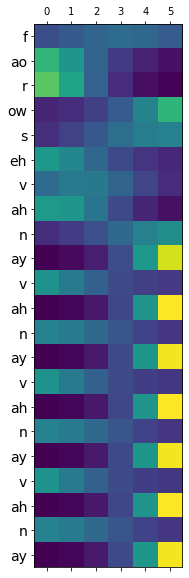

In [80]:
translate(testing[0], 6, sample_decoder_output.shape[1], phoneme_tokenizer)